<a href="https://colab.research.google.com/github/Squirtle007/CUDA_Quantum/blob/main/colab/cudaq_tutorial_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<style>
.custom-font {
    font-family: "Courier New", serif;
    font-size: 18px;
}
</style>

**Set up CUDA Quantum Environment**

In [1]:
#The following commands are used to set up the environment in Colab
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-keyring_1.0-1_all.deb
!dpkg -i cuda-keyring_1.0-1_all.deb
!apt-get update
!apt-get -y install libcublas-11-8 libcusolver-11-8 cuda-cudart-11-8

%pip install cuda-quantum==0.6.0

--2024-04-09 10:10:47--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-keyring_1.0-1_all.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4332 (4.2K) [application/x-deb]
Saving to: ‘cuda-keyring_1.0-1_all.deb’

cuda-keyring_1.0-1_ 100%[===================>]   4.23K  --.-KB/s    in 0s      

2024-04-09 10:10:47 (239 MB/s) - ‘cuda-keyring_1.0-1_all.deb’ saved [4332/4332]

(Reading database ... 121753 files and directories currently installed.)
Preparing to unpack cuda-keyring_1.0-1_all.deb ...
Unpacking cuda-keyring (1.0-1) over (1.0-1) ...
Setting up cuda-keyring (1.0-1) ...

A deprecated public CUDA GPG key appear to be installed.
To remove the key, run this command:
sudo apt-key del 7fa2af80

Get:1 https://developer.download.nvidia.com/compute/c

# CUDA Quantum 101

Important Links

* Installation
    https://nvidia.github.io/cuda-quantum/latest/install.html
* Documentation
    https://nvidia.github.io/cuda-quantum/latest/index.html
* CUDA Quantum repo
    https://github.com/NVIDIA/cuda-quantum


**Outline**

1. What is CUDA Quantum?
2. CUDA Quantum Kernels
3. Algorithmic primitives \
    3.1 cudaq.sample() \
    3.2 cudaq.spin_op() \
    3.3 cudaq.observe()
4. Parameterized circuits
5. Scalability 101

 ### 1. What is CUDA Quantum?


* An open-source platform for integrating and programming quantum processing units (QPUs), GPUS and CPUs in one system.

* Enables dynamic workflow between different system architectures.

* A programming model which extends C++ and Python with quantum kernels, enabling high-level programming in familiar languages.

* The ability to utilize and seamlessly switch between different quantum technologies, including state-of-the-art simulator backends with NVIDIA cuQuantum and a number of different physical quantum processors (QPUs).

In [24]:
# Import the CUDA Quantum module
import cudaq

### 2. CUDA Quantum Kernel

A common pattern in the design and implementation of accelerated-node programming models is the separation of accelerator-device code from existing CPU host code via function-level boundaries. This provides a clear delineation between what must be compiled for, and executed on, an available computational accelerator. The annotation of device code is common to aid programming model implementations in device code discovery, compilation, and runtime-library configuration and setup.CUDA Quantum follows a similar pattern.



In [25]:
# We begin by defining the `Kernel` that we will construct our
# program with.
kernel = cudaq.make_kernel()

In [26]:
# Next, we can allocate qubits to the kernel via `qalloc(qubit_count)`.
# An empty call to `qalloc` will return a single qubit.
qubit = kernel.qalloc()

In [27]:
# Now we can begin adding instructions to apply to this qubit!
# Here we'll just add every non-parameterized
# single qubit gates that are supported by CUDA Quantum.
kernel.h(qubit)
kernel.x(qubit)
kernel.y(qubit)
kernel.z(qubit)
kernel.t(qubit)
kernel.s(qubit)

In [28]:
# Next, we add a measurement to the kernel so that we can sample
# the measurement results on our simulator!
kernel.mz(qubit)

In [29]:
# Other methods and attributes available to the kernel object
#dir(kernel)
#help(kernel.tdg)

###     3. Algorithmic primitives

Algorithmic primitives are common programming patterns that have been implemented in the CUDA Quantum library.

3.1 cudaq.sample() \
3.2 cudaq.observe() \
3.3 cudaq.spin_op()

#### 3.1. cudaq.sample()


The sample() function performs multiple measurements of the circuit(1000 shots by default) and returns a dictionary of the measurement outcomes along with their respective counts.


In [30]:
# Finally, we can execute this kernel on the state vector simulator
# by calling `cudaq.sample`. This will execute the provided kernel
# `shots_count` number of times and return the sampled distribution
# as a `cudaq.SampleResult` dictionary.
sample_result = cudaq.sample(kernel)

# Now let's take a look at the `SampleResult` we've gotten back!
print(sample_result)  # or result.dump()

{ 0:477 1:523 }



Putting it all together!

In [31]:
import cudaq

kernel = cudaq.make_kernel()
qubit = kernel.qalloc(2)

kernel.h(qubit)
kernel.x(qubit)
kernel.y(qubit)
kernel.z(qubit)
kernel.t(qubit)
kernel.s(qubit)

kernel.mz(qubit)

# 1000 is the default
sample_result = cudaq.sample(kernel, shots_count=2000)

print(sample_result)  # or sample_result.dump()

{ 00:481 10:523 01:514 11:482 }



In [32]:
# Other methods and attributes available to the kernel object
#dir(sample_result)
#help(sample_result.values)

In [33]:
# Extracting data from sample

print(f"most probable = {sample_result.most_probable()}")
print(f"expectation_value = {sample_result.expectation()}")
print(f"count = {sample_result.count('01')}")
print(f"probability = {sample_result.probability('01')}")


most probable = 10
expectation_value = -0.03700000000000003
count = 514
probability = 0.257


In [34]:
# clear results, result should now be empty
sample_result.clear()

####  3.2. cudaq.spin_op()


The spin_op represents a general sum of Pauli tensor products. It exposes the typical algebraic operations that allow programmers to define primitive Pauli operators and use them to compose larger, more complex Pauli tensor products and sums thereof.

Let's say our Hamitonian is $Z_0 \otimes I_1 + I_0 \otimes X_1 + Y_0 \otimes I_1 + Y_0 \otimes Y_1$.

In [35]:
# Importing the spin_op
from cudaq import spin

# the obseravle
hamiltonian = spin.z(0) + spin.x(1) + spin.y(0) + spin.y(0)*spin.y(1)
#hamiltonian.dump()

In [36]:
#dir(hamiltonian)
#help(hamiltonian.dump)

#### 3.3. cudaq.observe()


Compute the expected value of the observable.

In [37]:
# First we need to construct a cuda quantum kernel
kernel = cudaq.make_kernel()
qreg = kernel.qalloc(2)
kernel.x(qreg[0])

In [38]:
# The cudaq.observe() takes the quantum circuit and the observable as input params
observe_result = cudaq.observe(kernel, hamiltonian, shots_count=1000)

In [39]:
#print(observe_result.dump())
observe_result.expectation()

-0.988

In [40]:
# For a complete list of attributes
# dir (observe_result)

    Putting it all together!

In [41]:
import cudaq
from cudaq import spin

# First we need to construct a cuda quantum kernel
kernel = cudaq.make_kernel()
qreg = kernel.qalloc(2)
kernel.x(qreg[0])

# The cudaq.observe() takes the quantum circuit and the observable as input params
observe_result = cudaq.observe(kernel, hamiltonian, shots_count=10000)

#print(observe_result.dump())
observe_result.expectation()

-0.9581999999999999

### 4. Parameterized circuits

In [42]:
import cudaq
from cudaq import spin

# the obserable
hamiltonian = 5.907 - 2.1433 * spin.x(0) * spin.x(1) \
            - 2.1433 * spin.y(0) * spin.y(1) + 0.21829 * spin.z(0) \
            - 6.125 * spin.z(1)

# parameterized cudaq kernel, the parameter is of type float
kernel, theta = cudaq.make_kernel(float)
q = kernel.qalloc(2)
kernel.x(q[0])
kernel.ry(theta, q[1])
kernel.cx(q[1], q[0])

# observe() takes the kernel, the observable and the kernel paramter(s)
# as args
observe_result = cudaq.observe(kernel, hamiltonian, .59)
#print(observe_result.dump())
observe_result.expectation()

-1.7487943680728968

### 5. Power of GPU acceleration 101

Make sure that that your Docker container was launched with the `--gpus all` flag turned on.

Bell State
$\dfrac{1}{\sqrt{2}}(|00\rangle +|11\rangle)$, maximally entangled 2-qubit state.

GHZ state
$\dfrac{1}{\sqrt{2}}(|0\rangle^{\otimes N} +|1\rangle^{\otimes N})$, maximally entangled N-qubit state, $N \ge 3$.

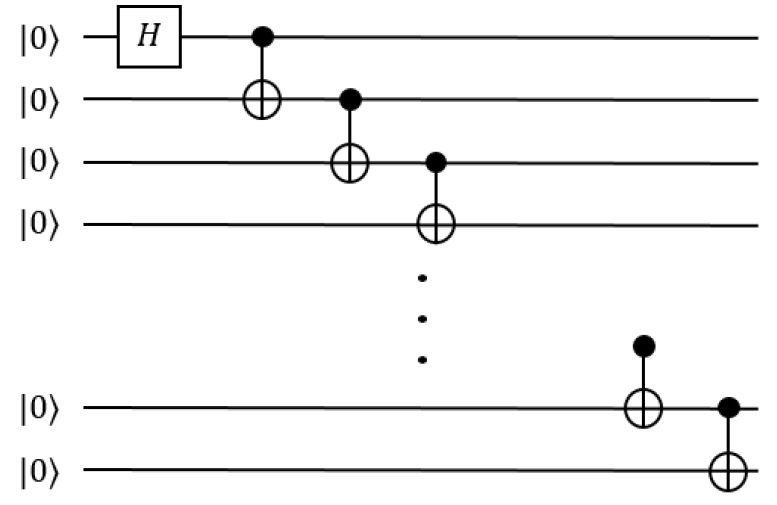

In [43]:
# To run with available gpu using a command line flag:
# python3 ghz_state.py --target nvidia
# To run with cpu (very slow) using a command line flag:
# python3 ghz_state.py


import cudaq

cudaq.set_target("nvidia") # change target to "qpp-cpu" for cpu

def ghz_state(N):

    kernel = cudaq.make_kernel()
    q = kernel.qalloc(N)

    kernel.h(q[0])
    for i in range(N - 1):
      kernel.cx(q[i], q[i + 1])

    kernel.mz(q)
    return kernel

n = 25
print("Preparing GHZ state for", n, "qubits.")
kernel = ghz_state(n)

import time
t0 = time.time()
counts = cudaq.sample(kernel)
print("The execution time:", time.time()-t0)

print(counts)

Preparing GHZ state for 25 qubits.
The execution time: 0.10102319717407227
{ 0000000000000000000000000:509 1111111111111111111111111:491 }

